<a href="https://colab.research.google.com/github/mhatre24yash/DSC212---Assignment-Mhatre-Yash-Jitendra-IMS24140/blob/main/IMS24140.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

heres the solution for the karate club data -

In [181]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import pandas as pd

lets load the karate club data

In [182]:
G = nx.karate_club_graph()
n = G.number_of_nodes()
m = G.number_of_edges()
nodes = list(G.nodes())

now, we calculate the properties needed for getting the modularity matrix B

In [183]:
A = nx.to_numpy_array(G, dtype=float)   # ndarray
k_vec = np.array([G.degree(i) for i in nodes]).reshape(-1, 1)
two_m = 2.0 * m                         # float to avoid any integer division issues


now we calculate the modularity matrix B

In [184]:
B_global = A - (k_vec @ k_vec.T) / two_m

we now plan to loop through to get community assignments

In [185]:
metric_history = defaultdict(lambda: defaultdict(dict))
iteration_count = 0
final_communities = []
community_assignments = {node: 0 for node in nodes}
fixed_layout = nx.spring_layout(G, seed=42)

In [186]:
def spectral_modularity_bisection(community_nodes, community_id):
    """
    Safe spectral bisection for community_nodes (list of node labels).
    Stops if lambda1 <= tol_eig, or if ΔQ <= tol_dq, or if split is trivial/duplicate.
    """
    global iteration_count, final_communities, processed_communities

    # canonical key for this community
    Cset = frozenset(community_nodes)
    if Cset in processed_communities:
        return
    processed_communities.add(Cset)

    # trivial
    if len(community_nodes) < 2:
        final_communities.append(set(community_nodes))
        return

    # build restricted B_C as ndarray
    node_indices = [nodes.index(node) for node in community_nodes]
    B_C = np.asarray(B_global)[np.ix_(node_indices, node_indices)]

    # leading eigenpair
    try:
        eigvals, eigvecs = np.linalg.eigh(B_C)
    except np.linalg.LinAlgError:
        print(f"LinAlgError: skipping community {community_id}")
        final_communities.append(set(community_nodes))
        return

    lambda_1 = float(eigvals[-1])
    u_1 = np.array(eigvecs[:, -1]).flatten()

    # tolerances
    tol_eig = 1e-15
    tol_dQ = 1e-15

    # stop if not positive eigenvalue
    if lambda_1 <= tol_eig:
        final_communities.append(set(community_nodes))
        return

    # sign partition
    s = np.sign(u_1)
    s[s == 0] = -1.0
    C_plus_nodes = [community_nodes[i] for i in range(len(s)) if s[i] > 0]
    C_minus_nodes = [community_nodes[i] for i in range(len(s)) if s[i] < 0]

    # reject trivial split
    if len(C_plus_nodes) == 0 or len(C_minus_nodes) == 0:
        final_communities.append(set(community_nodes))
        return

    # ΔQ = (1 / (4m)) * s^T B_C s
    s_vec = s.reshape(-1, 1)
    # compute inner product then squeeze to a scalar
    raw = (s_vec.T @ (B_C @ s_vec)) / (4.0 * m)
    ΔQ = float(np.squeeze(raw))   # safe scalar extraction

    # require positive modularity gain
    if ΔQ <= tol_dQ:
        final_communities.append(set(community_nodes))
        return

    # accept split: assign new IDs; keep explicit ids for both children
    new_id_plus = community_id
    new_id_minus = max(community_assignments.values()) + 1

    for node in C_plus_nodes:
        community_assignments[node] = new_id_plus
    for node in C_minus_nodes:
        community_assignments[node] = new_id_minus

    iteration_count += 1
    compute_metrics(G, iteration_count)
    visualize_split(G, community_assignments, iteration_count)

    # enqueue children (only if they can be split)
    if len(C_plus_nodes) >= 2:
        queue.append((C_plus_nodes, new_id_plus))
    if len(C_minus_nodes) >= 2:
        queue.append((C_minus_nodes, new_id_minus))


lets define the function to calculate the metrics of a function
this shall also include the for loop to store the values

In [187]:
def compute_metrics(G, iteration):
    """Computes the four required node metrics using NetworkX functions."""
    metrics = {
        'Degree Centrality': nx.degree_centrality(G),
        'Betweenness Centrality': nx.betweenness_centrality(G),
        'Closeness Centrality': nx.closeness_centrality(G),
        'Clustering Coefficient': nx.clustering(G)
    }

    for metric_name, values in metrics.items():
        for node, value in values.items():
            metric_history[metric_name][node][iteration] = value

now we define another function to visualize the split a.k.a. draw the graph with different colors for different communities

In [188]:
def visualize_split(G, community_map, iteration):
    """Draws the graph with nodes colored by their current community assignment."""
    plt.figure(figsize=(10, 8))

    # Create a list of colors based on the community map
    # A simple color palette for communities
    colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#33FFF6', '#A133FF', '#FFD133']
    node_colors = [colors[community_map[node] % len(colors)] for node in nodes]

    # Draw the graph using the fixed layout
    nx.draw(
        G,
        pos=fixed_layout,
        node_color=node_colors,
        with_labels=True,
        node_size=600,
        font_size=10,
        font_color='black',
        edge_color='gray',
        linewidths=1,
        alpha=0.8
    )

    num_communities = len(set(community_map.values()))
    plt.title(f"Iteration {iteration}: Community Partition ({num_communities} Communities Detected)", fontsize=16)
    plt.show()



now we define the recursive function to repeat the bisection such that the modularity is maximized

now that all the functions required are defined, let us start the actual execution of the spectral clustering

In [189]:
print("--- Starting Spectral Modularity Partitioning ---")
print(f"Graph: {n} nodes, {m} edges.")


--- Starting Spectral Modularity Partitioning ---
Graph: 34 nodes, 78 edges.


first iterations goesss

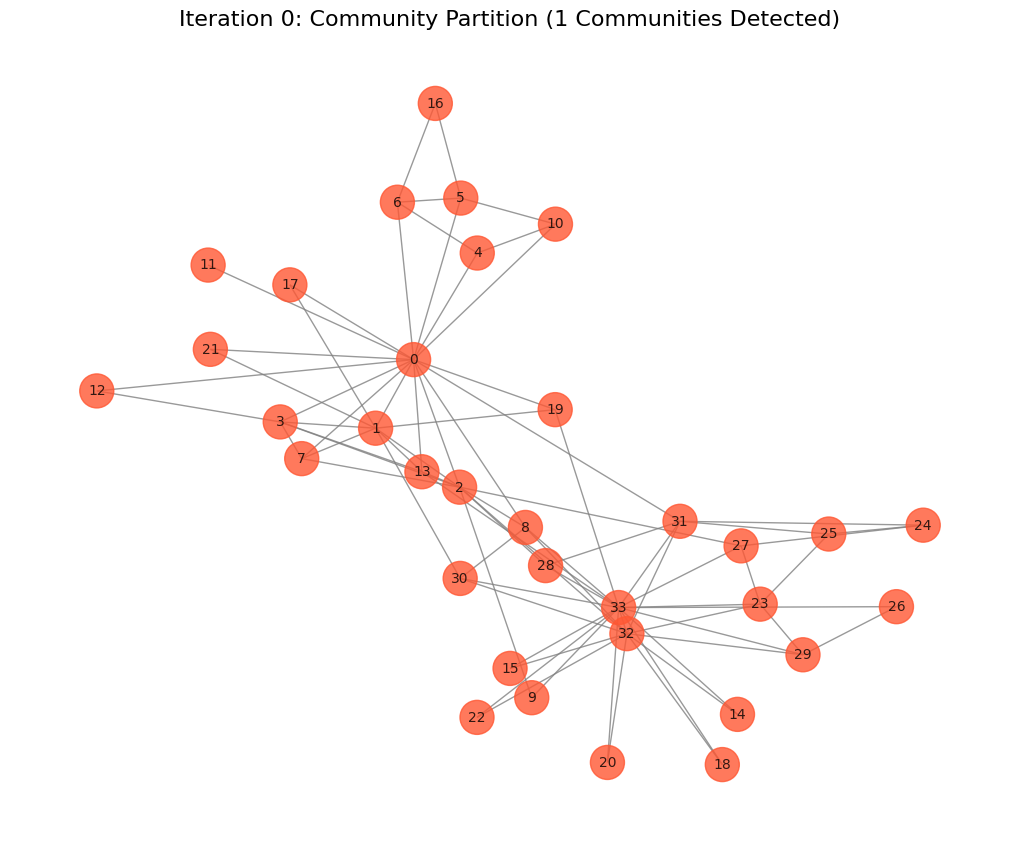

In [190]:
initial_community = nodes
initial_community_id = 0
processed_communities = set()
compute_metrics(G, iteration_count)
visualize_split(G, community_assignments, iteration_count)

using a double ended queue for the communities to be processed

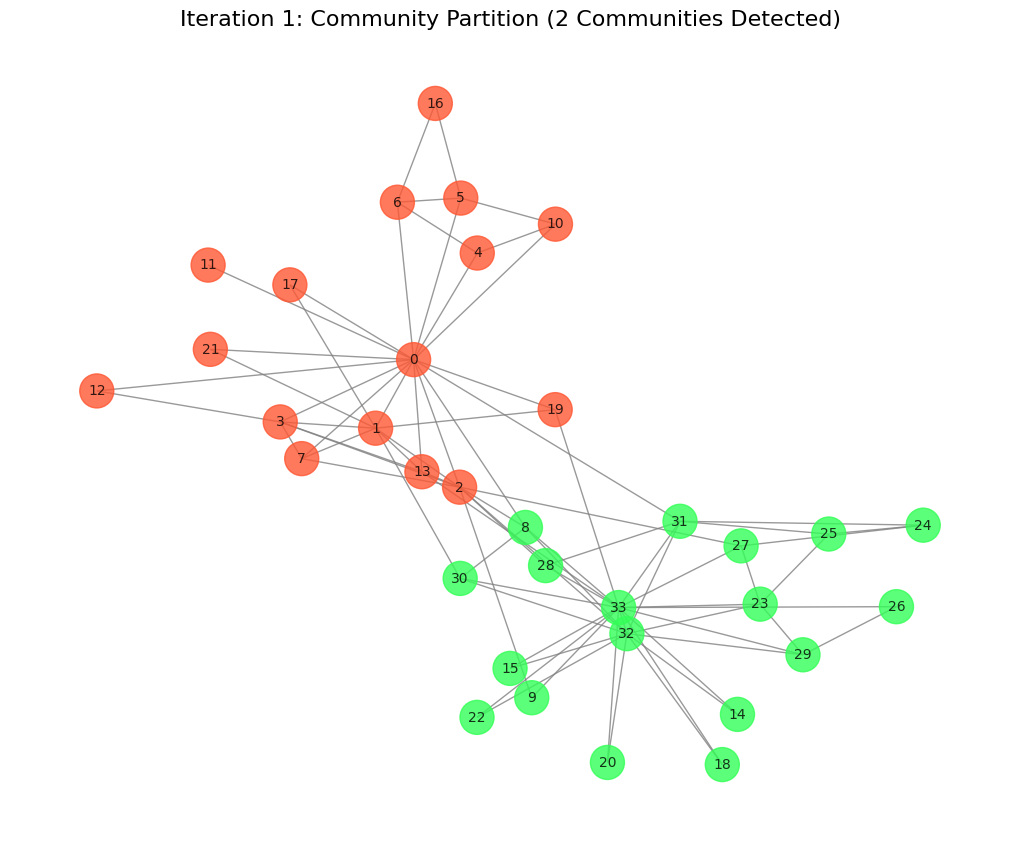

In [191]:
queue = deque([(initial_community, initial_community_id)])

while queue:
    current_community, current_id = queue.popleft()
    spectral_modularity_bisection(current_community, current_id)


now that we have finished the clustering, we shall print the iteration number

In [192]:
print("\n--- Partitioning Complete ---")
print(f"Total iterations (splits): {iteration_count}")


--- Partitioning Complete ---
Total iterations (splits): 1


we shall print the modularity scores now

In [193]:
final_assignment_vector = np.zeros((n, 1))
community_to_sign = {
    c_id: 1 if c_id % 2 == 0 else -1
    for c_id in set(community_assignments.values())
}
for i, node in enumerate(nodes):
    c_id = community_assignments[node]
    # Simple assignment of +1 or -1 for Q score calculation (can be arbitrary)
    final_assignment_vector[i] = community_to_sign[c_id]
Q_score = (1 / (4 * m)) * final_assignment_vector.T @ B_global @ final_assignment_vector

print(f"Final Modularity Score (Q): {Q_score[0, 0]:.4f}")

from networkx.algorithms.community import modularity

# Build partition as list-of-sets from community_assignments
partition_map = defaultdict(list)
for node, cid in community_assignments.items():
    partition_map[cid].append(node)
partition = [set(members) for members in partition_map.values()]

Q_score_nx = modularity(G, partition)
print(f"Final Modularity Score (networkx.modularity): {Q_score_nx:.4f}")

Final Modularity Score (Q): 1.1984
Final Modularity Score (networkx.modularity): 0.4036


now, lets calculate the metric scores at each step


--- Plotting Metric Evolution ---


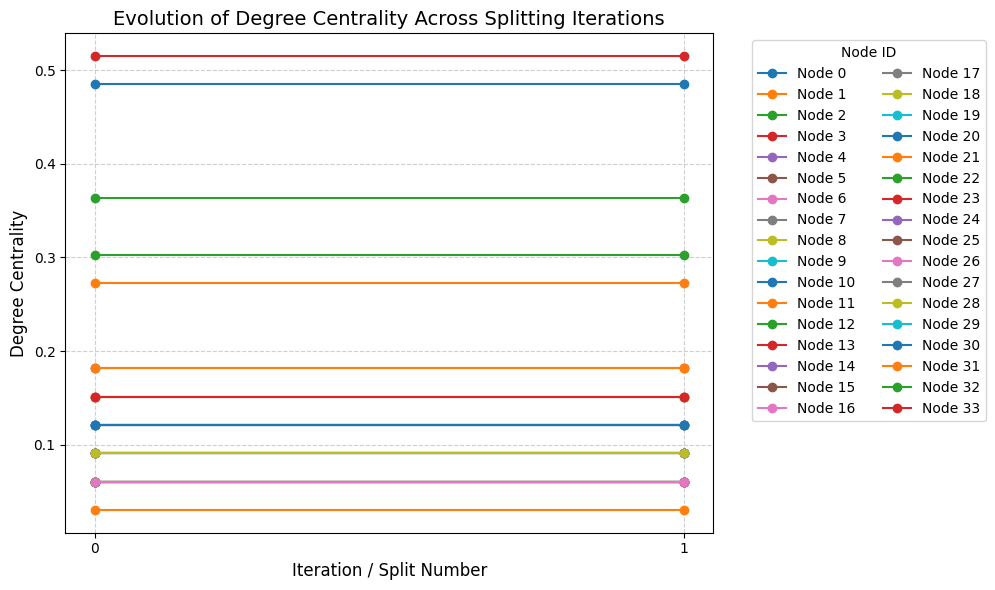

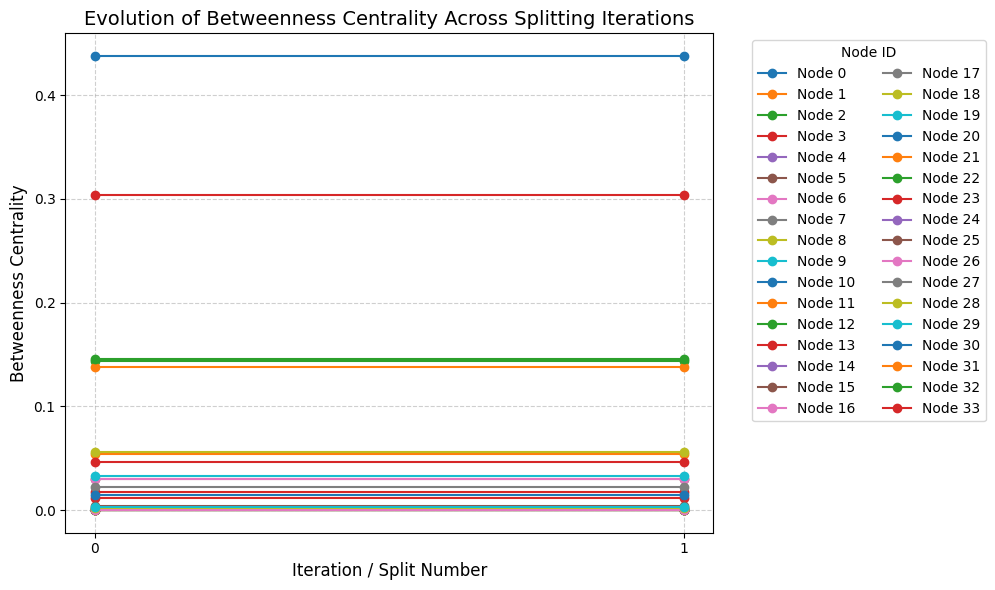

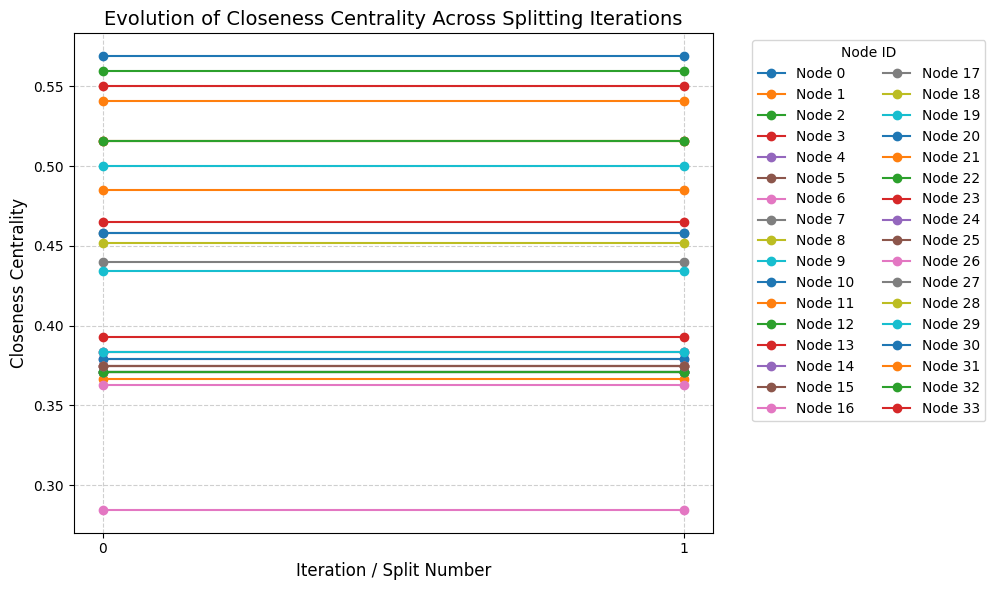

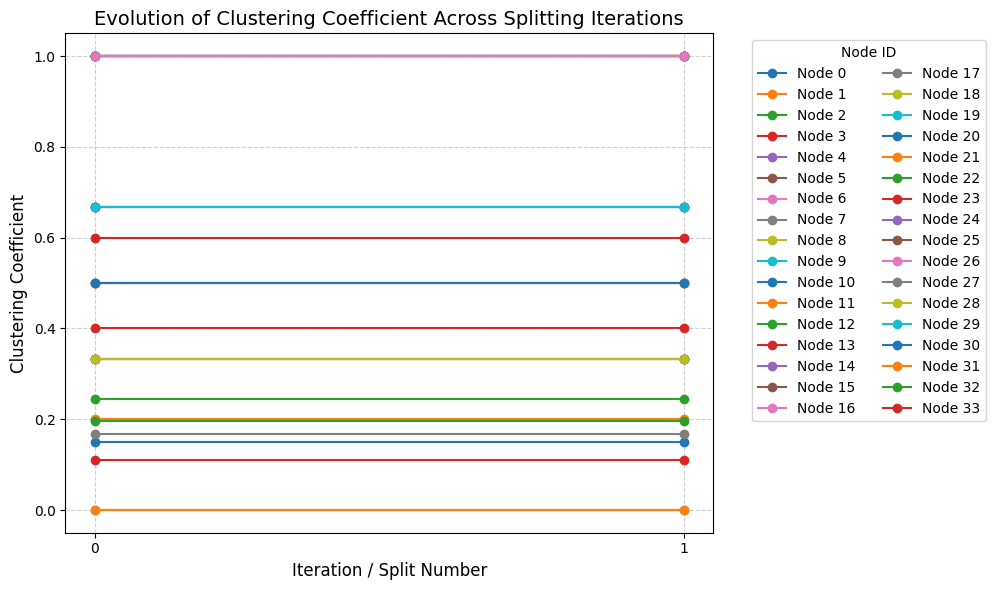

In [194]:
print("\n--- Plotting Metric Evolution ---")

def plot_metric_evolution(metric_name):
    """Plots the evolution of a single metric for all nodes across iterations."""
    df_data = {}

    # Reformat data into a DataFrame for easy plotting
    for node in nodes:
        node_data = {
            k: metric_history[metric_name].get(node, {}).get(k, np.nan)
            for k in range(iteration_count + 1)
        }
        df_data[node] = pd.Series(node_data)

    df = pd.DataFrame(df_data)

    plt.figure(figsize=(12, 6))

    # Plot each node as a separate line
    for node in nodes:
        plt.plot(df.index, df[node], marker='o', linestyle='-', label=f'Node {node}')

    plt.title(f'Evolution of {metric_name} Across Splitting Iterations', fontsize=14)
    plt.xlabel('Iteration / Split Number', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.xticks(range(iteration_count + 1))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, title='Node ID')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()




plot_metric_evolution('Degree Centrality')
plot_metric_evolution('Betweenness Centrality')
plot_metric_evolution('Closeness Centrality')
plot_metric_evolution('Clustering Coefficient')


Discussion  :

---


-as seen from the above graphs, the community gets split into two factions after the single iteration. due to negative modularities if the graph is split more, this is the only split that we get.

-moreover, the nodes 00 (the instructor Mr Hi) and node 33(the admin) consistently happen to be central to the split. their degree, closeness, betweenness centrality all remain fairly high across both iterations, because they are the main linkers across the entire graph, and it is the split between them that is affecting the entire club.

-as the graph is recursively partitioned, the nodes that act as bridges between the new communities, show high betweenness centrality, which decreases as the split members isolate their neighbours into separate smaller groups.

-whereas, the clustering coefficients tend to be stable for nodes deep inside the clusters.

-hence, centrality is not an individual property of individual nodes, but helps us understand and guess how those nodes fit into the larger picture.